In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,22+1),'c':range(2,26+1),'d':range(2,30+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

In [2]:
data={}

stouts=range(6,11)
stouts=range(0,41)
flas=[f'jg;stout{stout}' for stout in stouts] + ['j+','j-','js','jc']
for ens in enss:
    data[ens]={}
    tfs=ens2tfs[ens]

    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test2.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=yu.jackknife(f['N_mom0'])
        data[ens]['N1']=yu.jackknife(f['N_mom1'])
        
        data[ens]['P44']={}
        data[ens]['P4i']={}
        data[ens]['P44_vev']={}
        for fla in flas:
            print(ens,fla,end='           \r')
            if ens=='e' and fla!='s':
                continue
                
            data[ens]['P44'][fla]={}
            data[ens]['P4i'][fla]={}
            for tf in tfs:
                data[ens]['P44'][fla][tf]=yu.jackknife(f[f'{fla}/P44(G0,0,0)/{tf}'][:])
                data[ens]['P4i'][fla][tf]=yu.jackknife(f[f'{fla}/P4i(G0,pi,pi)/{tf}'][:])
                
            data[ens]['P44_vev'][fla]=yu.jackknife(f[f'{fla}/P44(G0,0,0)_vev'])

In [3]:
ens2RCs={}
for ens,ensL in zip(['b','c','d'],['cB64','cC80','cD96']):
    path=f'/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/z_gg_4D_{ensL}.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        t=[[float(ele) for ele in row.split(' ')] for row in t]
        ens2RCs[ens]=t

1 

2 symmetrized

3 2 + half tf

4 3 + half tc

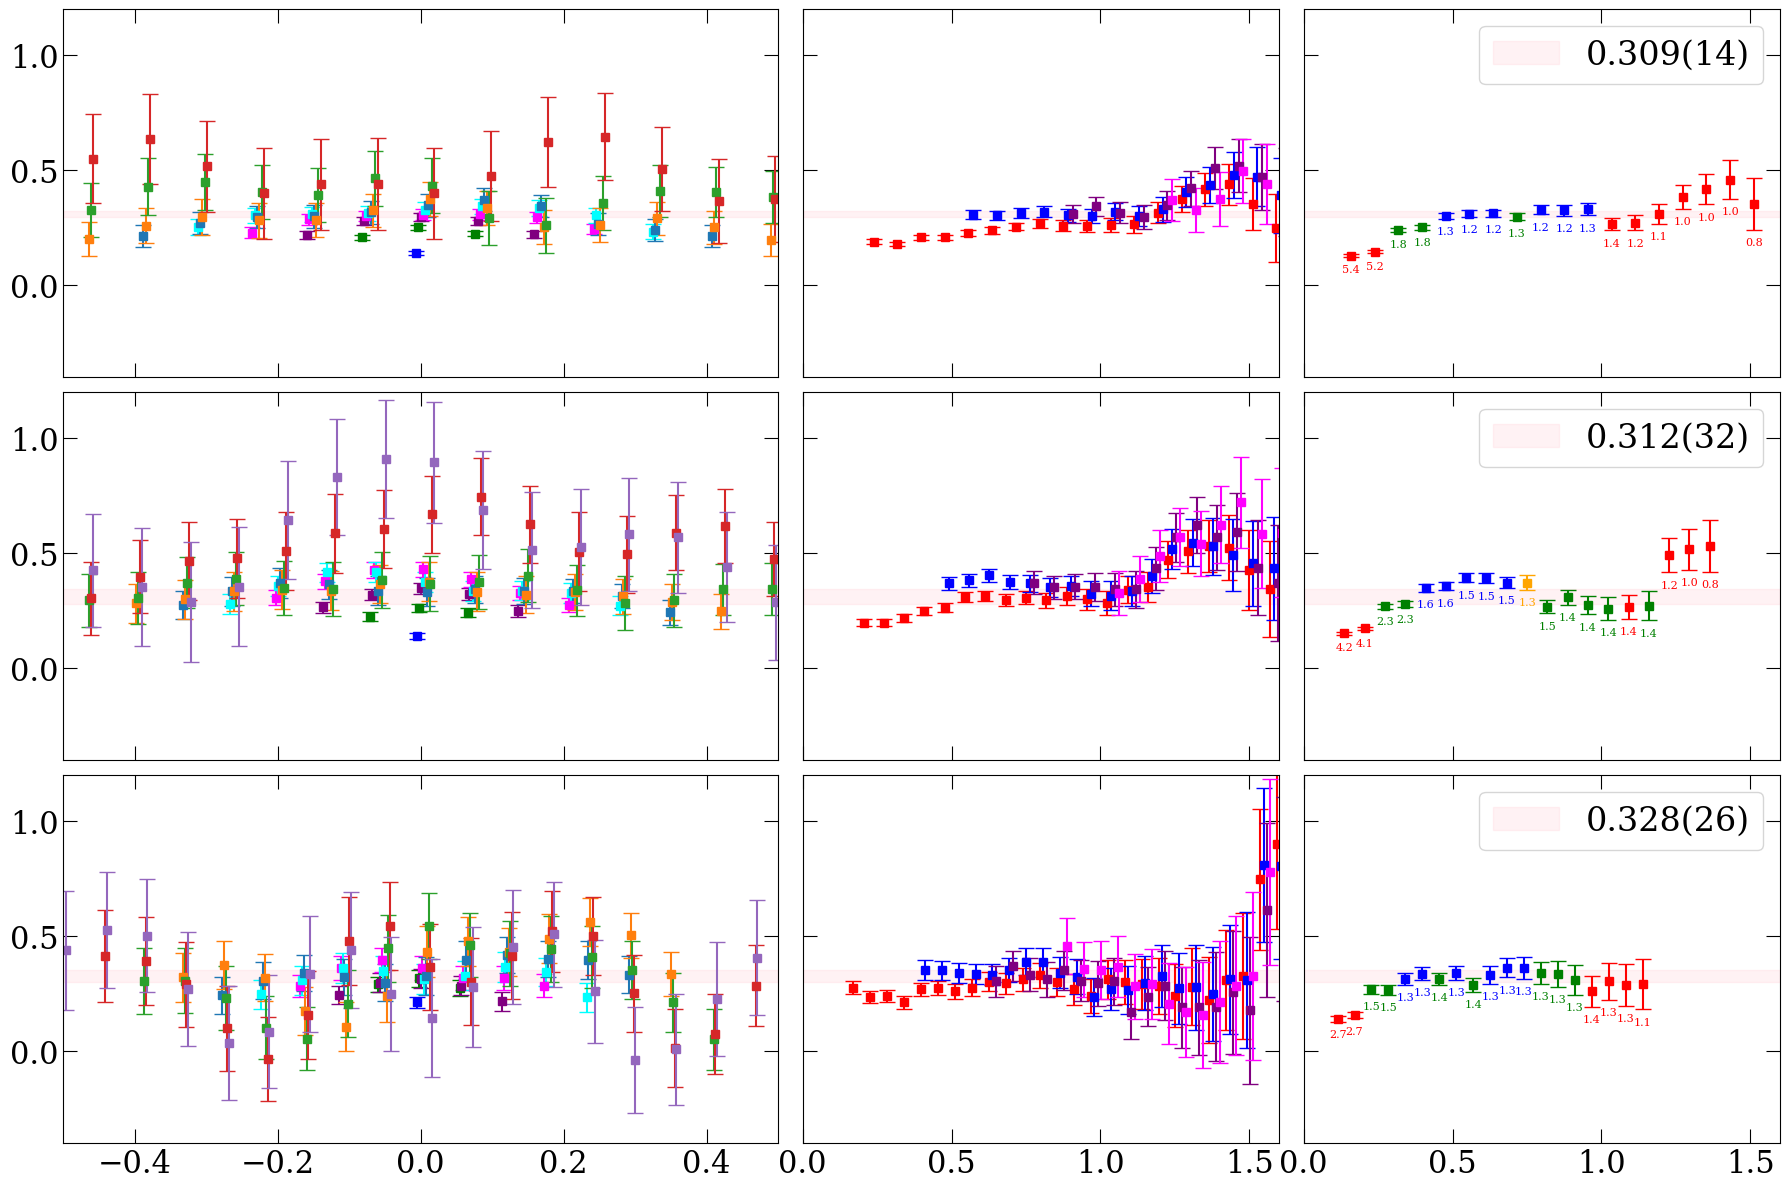

In [ ]:
enss_plt=['b','c','d']

xlim0=[-0.5,0.5]
xlim1=[0,1.6]
xlim2=[0,1.6]
xlim3=[0,1.6]

ylim=[-0.4,1.2]

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,0].set_ylim(ylim)

symmetrizeQ=False

stout=10
j=f'jg;stout{stout}'


res={}; res2={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
    tfs=ens2tfs[ens]
    tfs_fit=[tf for tf in tfs]
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    for iratio,ratioDic in enumerate([ratioDic2]):
        cut_err=0.3
        tfmax_cut=find_t_cloest(ens,2)
        for tf in tfs:
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            t=err[tf//2]*yunit
            if t>cut_err:
                tfmax_cut=tf-1
                break
        # print(ens,tfmax_cut,find_t_cloest(ens,1.5))

        ax=axs[i_ens,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
        t_cut=1
        for i_tf,tf in enumerate(tfs_fit):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        # print(ens,tfmax_cut)
        
        tcmins=[1,2,3,4,5,6,7,8]
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            if tcmin not in [1,3,5,7]:
                continue
            for i_tf,tf in enumerate(tfs_fit):
                # if tf<tcmin*2:
                #     continue
                ratio=ratioDic[tf]
                if tf>2*tcmin:
                    y_jk=ratio[:,tcmin:tf-tcmin+1]
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
        
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                if symmetrizeQ:
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        res2[ens]=[pars_mean[0],pars_err[0]]
        for icol in [0,1,2]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==2:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend()
        
plt.tight_layout()
plt.savefig(f'fig/jg;stout10_1.pdf')

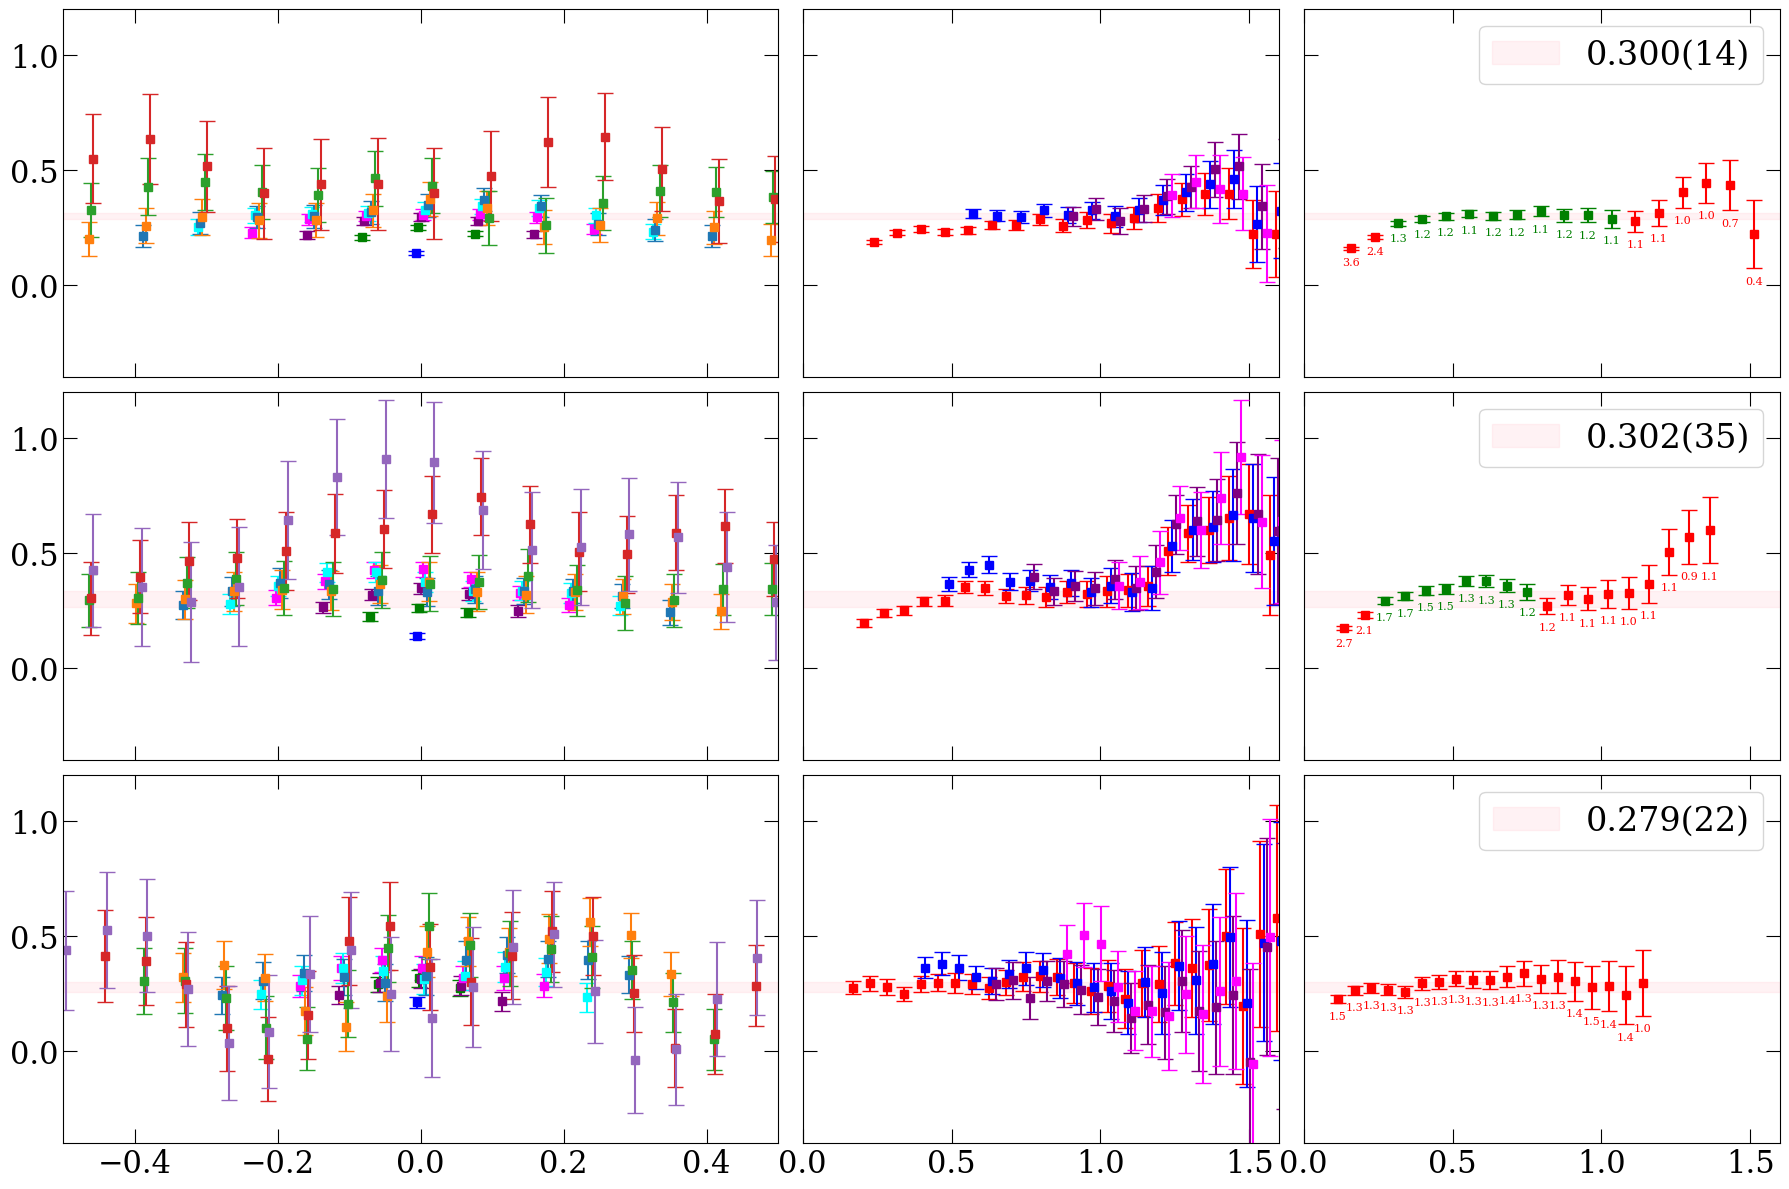

In [50]:
enss_plt=['b','c','d']

xlim0=[-0.5,0.5]
xlim1=[0,1.6]
xlim2=[0,1.6]
xlim3=[0,1.6]

ylim=[-0.4,1.2]

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,0].set_ylim(ylim)

symmetrizeQ=True

stout=10
j=f'jg;stout{stout}'

res={}; res2={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
    tfs=ens2tfs[ens]
    tfs_fit=[tf for tf in tfs]
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    for iratio,ratioDic in enumerate([ratioDic2]):
        cut_err=0.3
        tfmax_cut=find_t_cloest(ens,2)
        for tf in tfs:
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            t=err[tf//2]*yunit
            if t>cut_err:
                tfmax_cut=tf-1
                break

        ax=axs[i_ens,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
        t_cut=1
        for i_tf,tf in enumerate(tfs_fit):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        # print(ens,tfmax_cut)
        
        tcmins=[1,2,3,4,5,6,7,8]
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            if tcmin not in [1,3,5,7]:
                continue
            for i_tf,tf in enumerate(tfs_fit):
                # if tf<tcmin*2:
                #     continue
                ratio=ratioDic[tf]
                if tf>2*tcmin:
                    y_jk=ratio[:,tcmin:tf-tcmin+1]
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
        
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                if symmetrizeQ:
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        res2[ens]=[pars_mean[0],pars_err[0]]
        for icol in [0,1,2]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==2:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend()
        
plt.tight_layout()
plt.savefig('fig/jg;stout10_2.pdf')

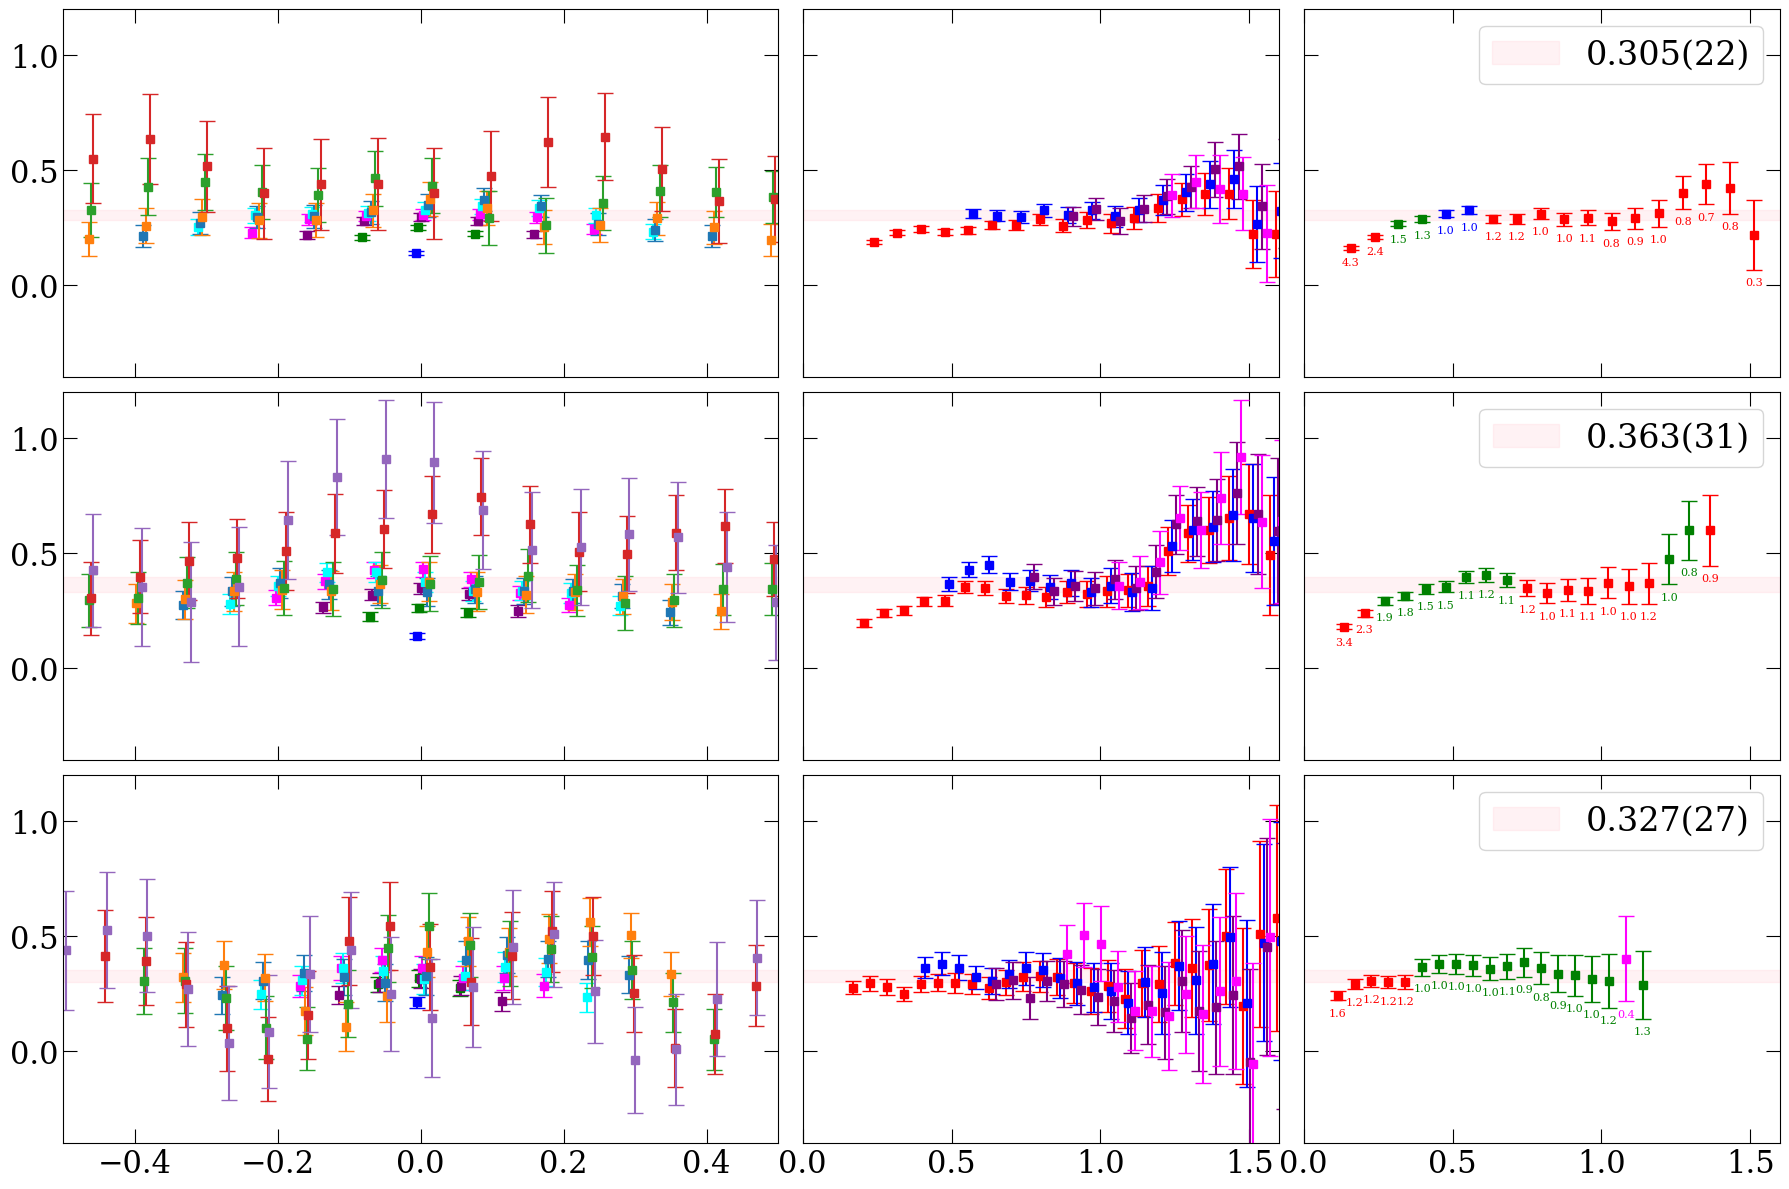

In [51]:
enss_plt=['b','c','d']

xlim0=[-0.5,0.5]
xlim1=[0,1.6]
xlim2=[0,1.6]
xlim3=[0,1.6]

ylim=[-0.4,1.2]

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,0].set_ylim(ylim)

symmetrizeQ=True

stout=10
j=f'jg;stout{stout}'

res={}; res2={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
    tfs=ens2tfs[ens]
    tfs_fit=[tf for tf in tfs]
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    for iratio,ratioDic in enumerate([ratioDic2]):
        cut_err=0.3
        tfmax_cut=find_t_cloest(ens,2)
        for tf in tfs:
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            t=err[tf//2]*yunit
            if t>cut_err:
                tfmax_cut=tf-1
                break

        ax=axs[i_ens,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
        t_cut=1
        for i_tf,tf in enumerate(tfs_fit):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        # print(ens,tfmax_cut)
        
        tcmins=[1,2,3,4,5,6,7,8]
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            if tcmin not in [1,3,5,7]:
                continue
            for i_tf,tf in enumerate(tfs_fit):
                # if tf<tcmin*2:
                #     continue
                ratio=ratioDic[tf]
                if tf>2*tcmin:
                    y_jk=ratio[:,tcmin:tf-tcmin+1]
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
        
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                if symmetrizeQ:
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        res2[ens]=[pars_mean[0],pars_err[0]]
        for icol in [0,1,2]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==2:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend()
        
plt.tight_layout()
plt.savefig('fig/jg;stout10_3.pdf')

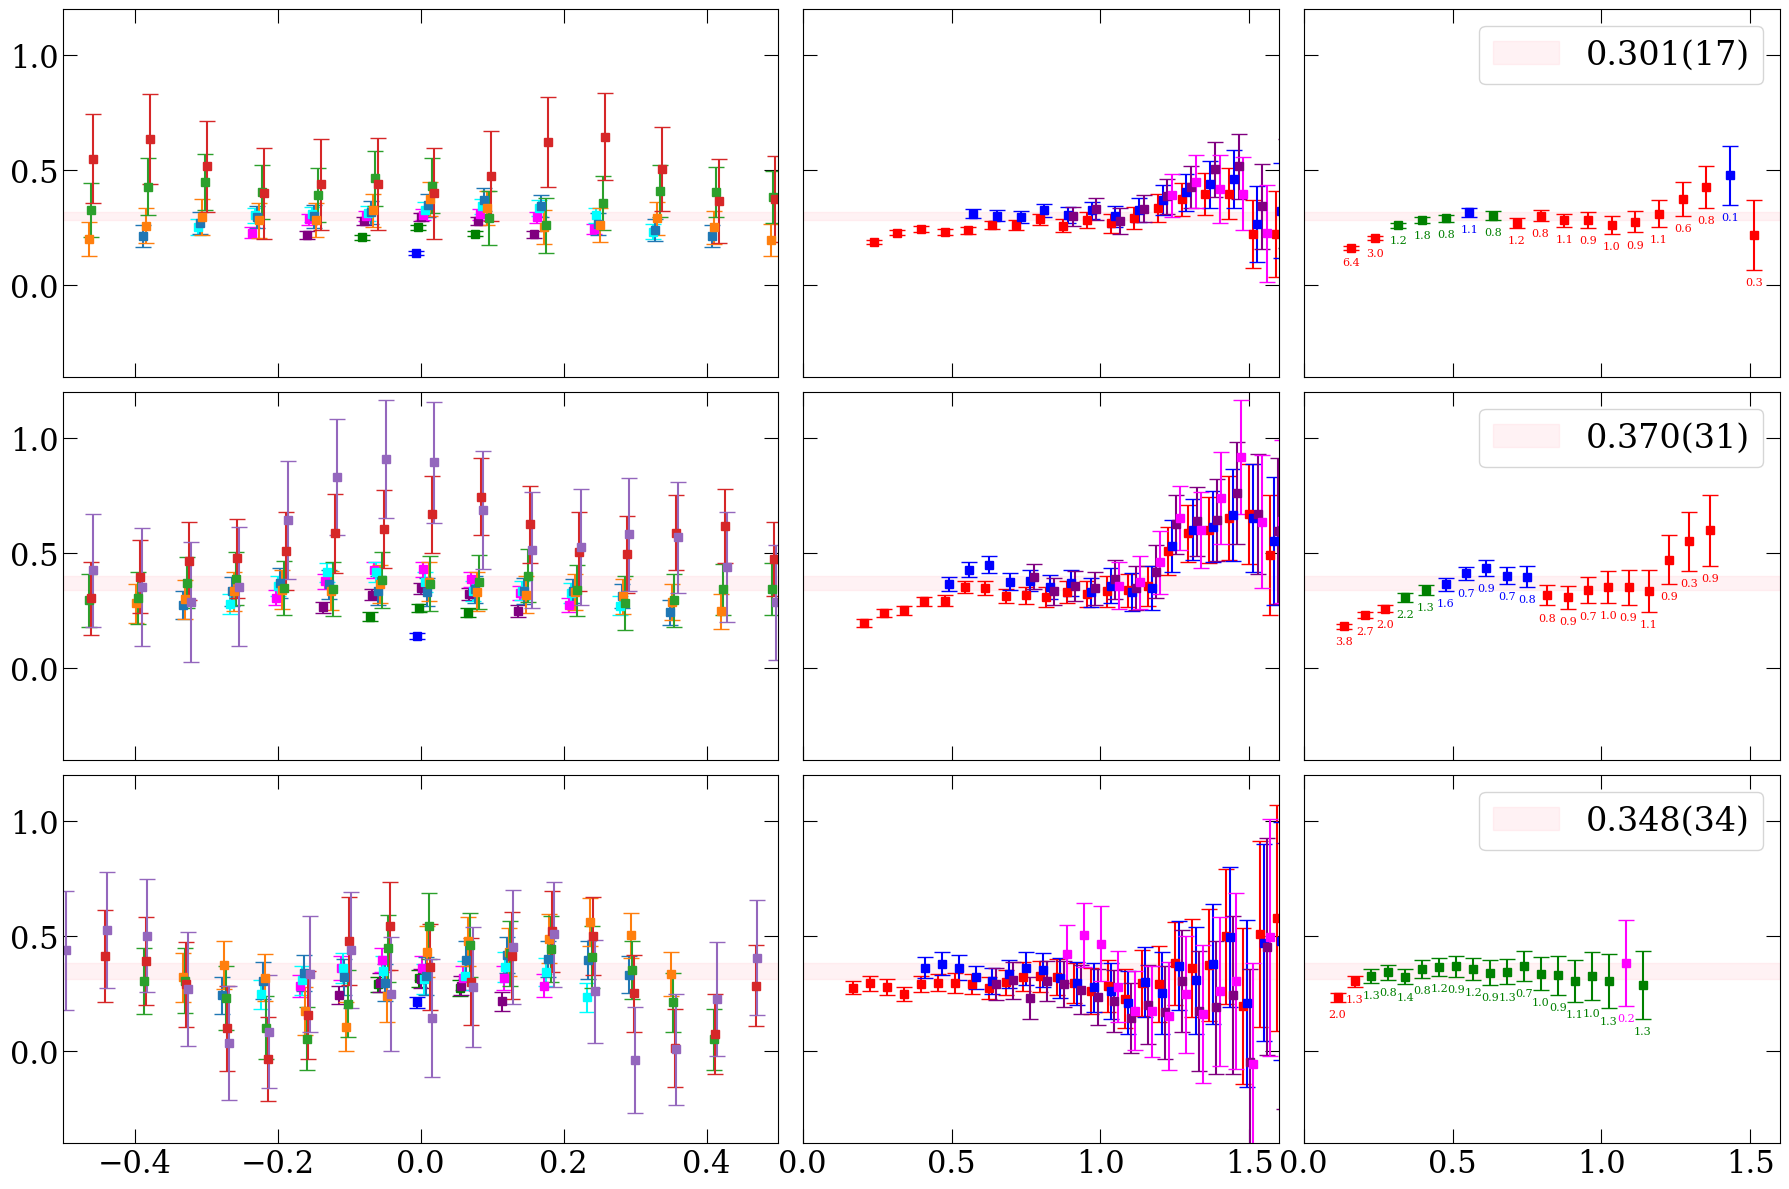

In [5]:
enss_plt=['b','c','d']

xlim0=[-0.5,0.5]
xlim1=[0,1.6]
xlim2=[0,1.6]
xlim3=[0,1.6]

ylim=[-0.4,1.2]

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,0].set_ylim(ylim)

symmetrizeQ=True

stout=10
j=f'jg;stout{stout}'

res={}; res2={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
    tfs=ens2tfs[ens]
    tfs_fit=[tf for tf in tfs]
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    for iratio,ratioDic in enumerate([ratioDic2]):
        cut_err=0.3
        tfmax_cut=find_t_cloest(ens,2)
        for tf in tfs:
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            t=err[tf//2]*yunit
            if t>cut_err:
                tfmax_cut=tf-1
                break

        ax=axs[i_ens,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
        t_cut=1
        for i_tf,tf in enumerate(tfs_fit):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        # print(ens,tfmax_cut)
        
        tcmins=[1,2,3,4,5,6,7,8]
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            if tcmin not in [1,3,5,7]:
                continue
            for i_tf,tf in enumerate(tfs_fit):
                # if tf<tcmin*2:
                #     continue
                ratio=ratioDic[tf]
                if tf>2*tcmin:
                    y_jk=ratio[:,tcmin:tf-tcmin+1]
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
        
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                try:
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                except:
                    continue
                if symmetrizeQ:
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        res2[ens]=[pars_mean[0],pars_err[0]]
        for icol in [0,1,2]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==2:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend()
        
plt.tight_layout()
plt.savefig('fig/jg;stout10_4.pdf')

# stability between methods

a=symmetrize

b=half tc

c=half tf

In [6]:
figFolder='downSamplingTest'

enss_plt=['d']

res1=[]
tfmax_cuts=range(16,31,2)

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=False

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res1.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

In [7]:
enss_plt=['d']

res2=[]
tfmax_cuts=range(16,31,2)

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=True

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res2.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

In [8]:
enss_plt=['d']

res3=[]
tfmax_cuts=range(16,31,2)

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=False

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res3.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

In [9]:
enss_plt=['d']

res4=[]

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=False

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res4.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

In [11]:
enss_plt=['d']

res5=[]

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=False

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res5.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

In [13]:
enss_plt=['d']

res6=[]

for tfmax_cut in tfmax_cuts:
    print(tfmax_cut,end='           \r')

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=True

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    if Ndof==0:
                        continue
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res6.append([tfmax_cut,plt_y,plt_err])
    plt.tight_layout()
    plt.close()
# plt.savefig('fig/jg;stout10_4.pdf')

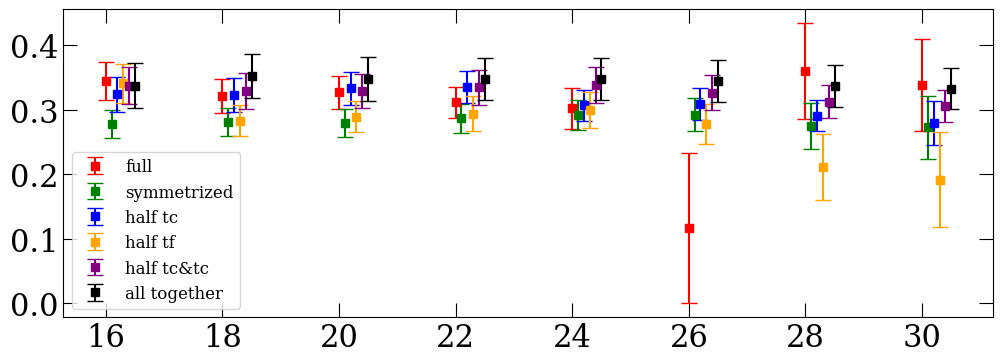

In [18]:
fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=12)
ax=axs[0,0]

# labels=['full','& symmetrized','& half tc','& half tf']
labels=['full','symmetrized','half tc','half tf', 'half tc&tc','all together']
colors=['r','g','b','orange','purple','black']
for ires,res in enumerate([res1,res2,res3,res4,res5,res6]):
    for x,y,yerr in res:
        plt_x=x+ires*0.1; plt_y=y; plt_yerr=yerr
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[ires],label=labels[ires] if x==res[0][0] else None) 

ax.legend(fontsize=12)
plt.savefig('fig/stability_tfcut.pdf')

# stouts compare

In [84]:
stouts_plt=range(3,13+1)
# stouts_plt=range(40+1)
enss_plt=['b','c','d']

res={}
for ens in enss_plt:
    res[ens]=[]
for stout in stouts_plt:
    print(stout,end='          \r')
    

    enss_plt=['b','c','d']

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=True

    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            cut_err=0.3
            tfmax_cut=find_t_cloest(ens,2)
            for tf in tfs:
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                t=err[tf//2]*yunit
                if t>cut_err:
                    tfmax_cut=tf-1
                    break
            tfmax_cut=find_t_cloest(ens,1.5)

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res[ens].append([stout,pars_mean[0],pars_err[0]])
            
    plt.tight_layout()
    plt.close()

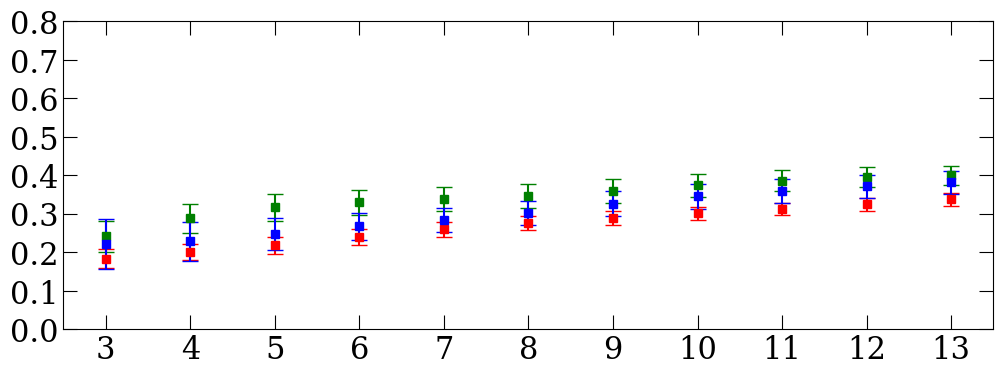

In [85]:
fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=12)
axs[0,0].set_xticks(stouts_plt)
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_yticks(np.arange(0,0.9,0.1))

colors=['r','g','b']

ax=axs[0,0]
for i_st,stout in enumerate(stouts_plt):
    for iens,ens in enumerate(enss_plt):
        yunit=ens2RCs[ens][stout][0]
        
        plt_x=stout; plt_y=res[ens][i_st][1]*yunit; plt_yerr=res[ens][i_st][2]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens])  

plt.savefig('fig/jg_1.5fm_4.pdf')

# backup

KeyboardInterrupt: 

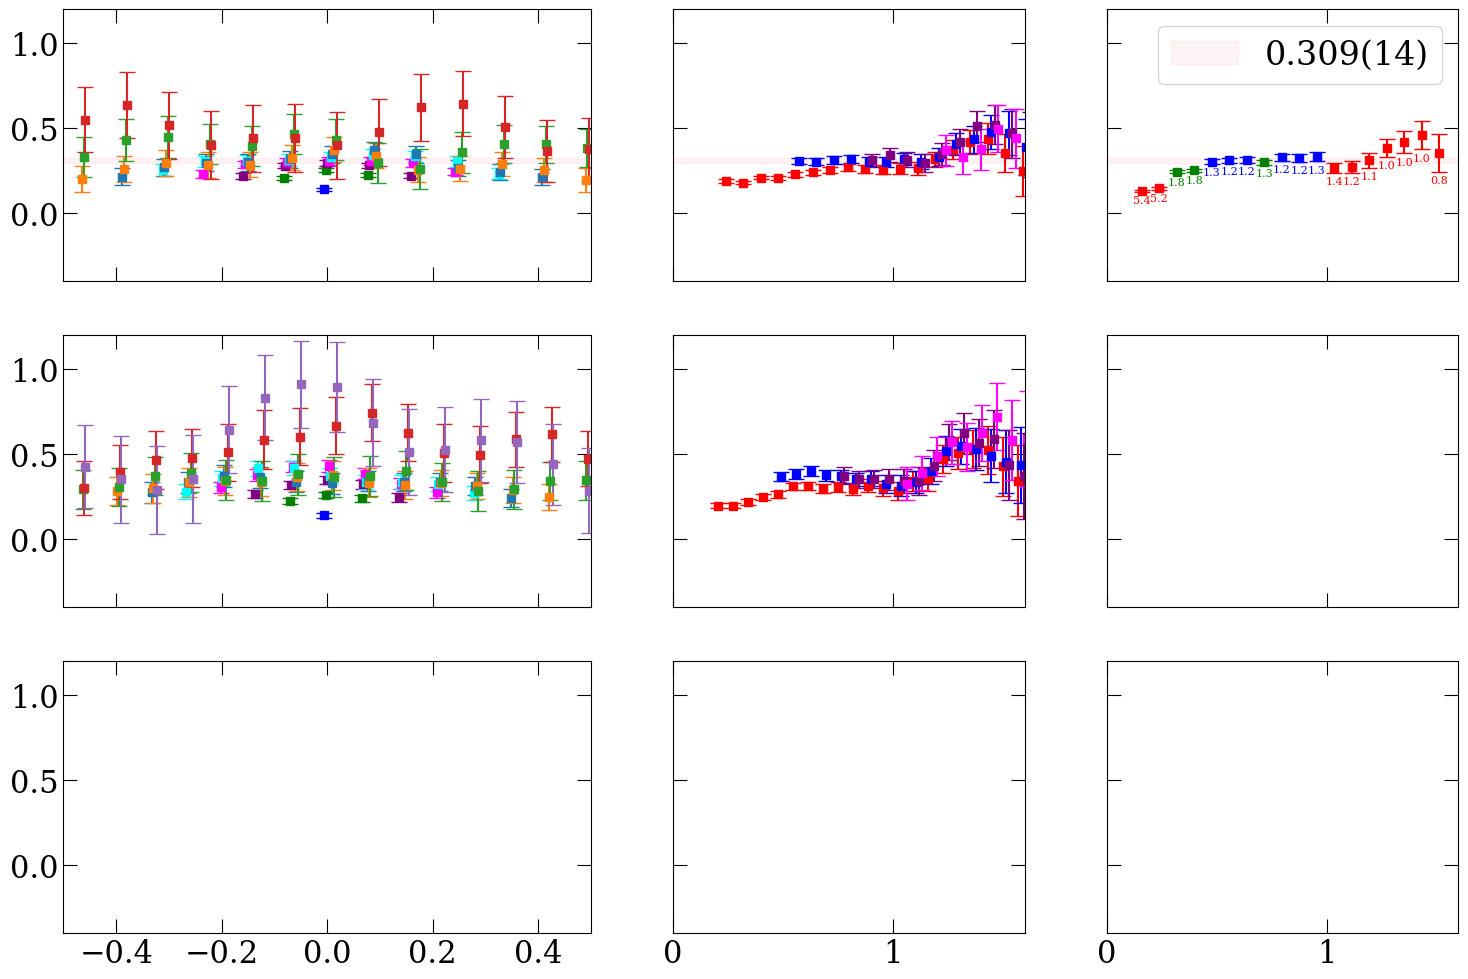

In [80]:
stouts_plt=range(3,13+1)
# stouts_plt=range(40+1)
enss_plt=['b','c','d']

res={}
for ens in enss_plt:
    res[ens]=[]
for stout in stouts_plt:
    print(stout,end='          \r')
    

    enss_plt=['b','c','d']

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=False

    stout=10
    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=ens2RCs[ens][stout][0]
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            cut_err=0.3
            tfmax_cut=find_t_cloest(ens,2)
            for tf in tfs:
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                t=err[tf//2]*yunit
                if t>cut_err:
                    tfmax_cut=tf-1
                    break

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res[ens].append([stout,pars_mean[0],pars_err[0]])
            
    plt.tight_layout()
    plt.close()

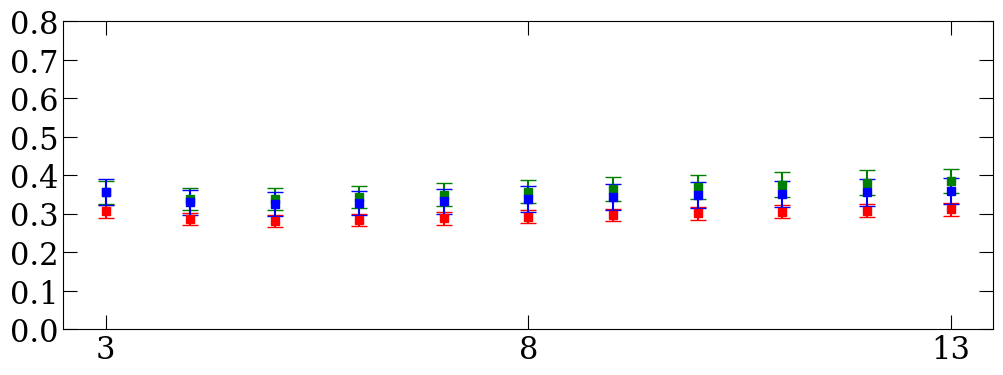

In [ ]:
fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=12)
axs[0,0].set_xticks(stouts_plt)
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_yticks(np.arange(0,0.9,0.1))

colors=['r','g','b']

ax=axs[0,0]
for i_st,stout in enumerate(stouts_plt):
    for iens,ens in enumerate(enss_plt):
        yunit=ens2RCs[ens][stout][0]
        
        plt_x=stout; plt_y=res[ens][i_st][1]*yunit; plt_yerr=res[ens][i_st][2]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens])  

plt.savefig('fig/jg_0.3err_1.pdf')

/tmp/ipykernel_1005227/712994310.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  chi2R=np.mean(chi2_jk)/Ndof


KeyboardInterrupt: 

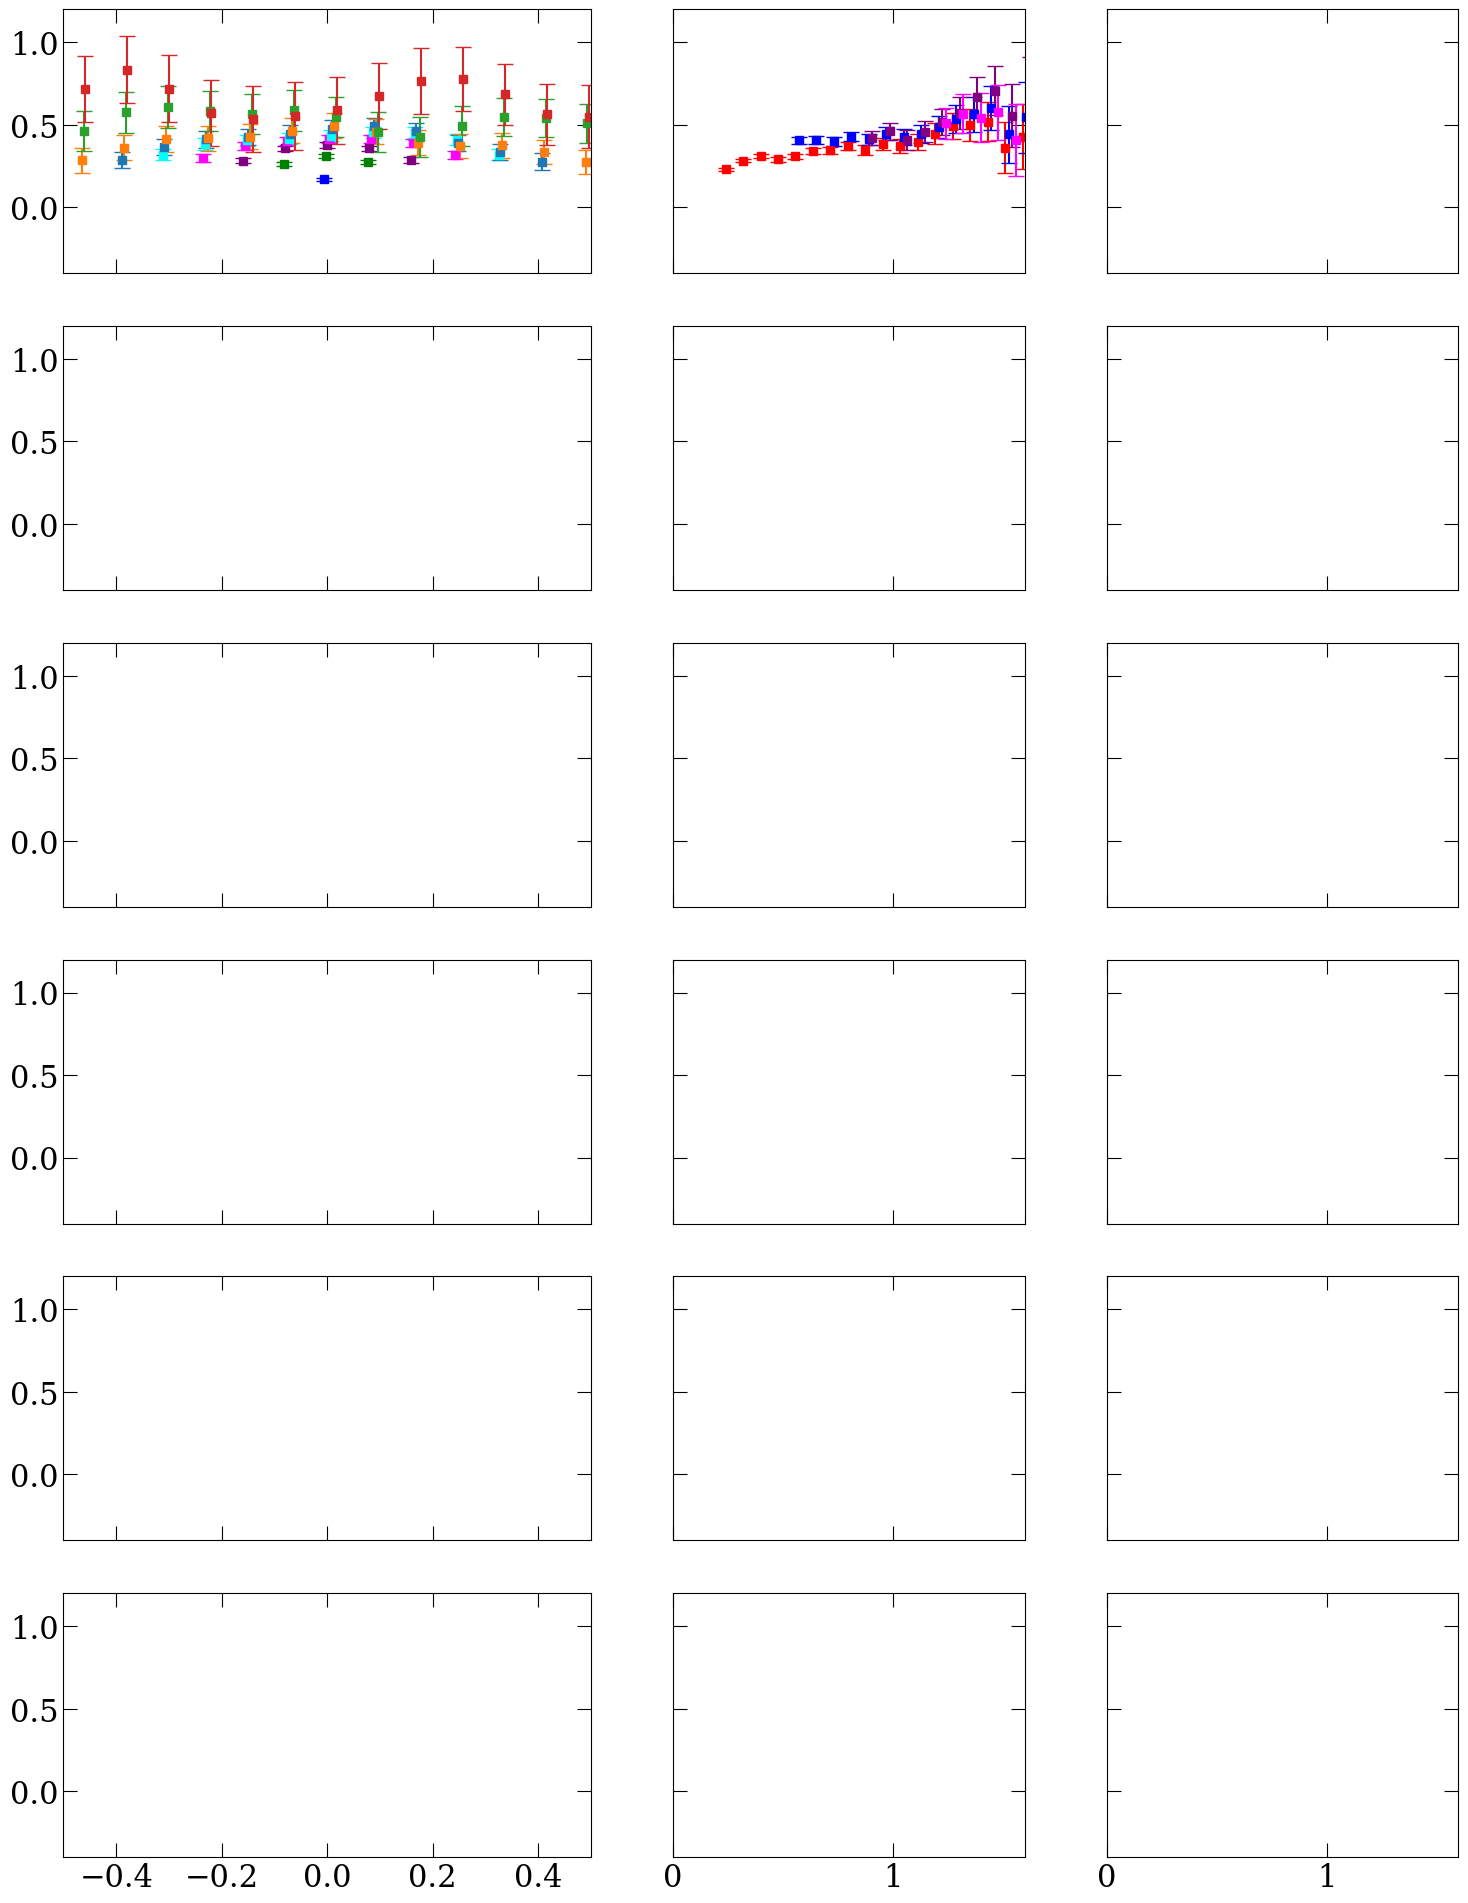

In [77]:
stouts_plt=range(3,13+1)
enss_plt=['b','c','d']

res={}
for ens in enss_plt:
    res[ens]=[]
for stout in stouts_plt:
    print(stout,end='          \r')
    

    xlim0=[-0.5,0.5]
    xlim1=[0,1.6]
    xlim2=[0,1.6]
    xlim3=[0,1.6]

    ylim=[-0.4,1.2]

    fix, axs = yu.getFigAxs(len(enss_plt)*2,3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=True

    j=f'jg;stout{stout}'

    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=1
        tfs=ens2tfs[ens]
        tfs_fit=[tf for tf in tfs]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        amN=938/ens2aInv[ens]
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
        
        c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

        for iratio,ratioDic in enumerate([ratioDic2]):
            cut_err=0.3
            tfmax_cut=find_t_cloest(ens,2)
            for tf in tfs:
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                t=err[tf//2]*yunit
                if t>cut_err:
                    tfmax_cut=tf-1
                    break

            # tfmax_cut=find_t_cloest(ens,1.5)

            ax=axs[iratio,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs_fit):
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=[1,2,3,4,5,6,7,8]
            ax=axs[iratio,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                if tcmin not in [1,3,5,7]:
                    continue
                for i_tf,tf in enumerate(tfs_fit):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[iratio,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    
                    if len(y_jk)<=1:
                        continue

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs_fit.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[iratio,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            res[ens].append([stout,pars_mean[0],pars_err[0]])
            
    plt.tight_layout()
    plt.close()

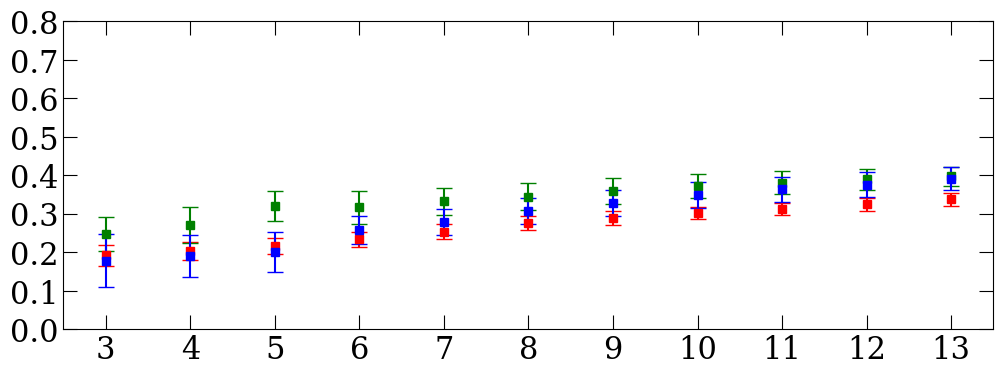

In [76]:
fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=12)
axs[0,0].set_xticks(stouts_plt)
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_yticks(np.arange(0,0.9,0.1))

colors=['r','g','b']

ax=axs[0,0]
for i_st,stout in enumerate(stouts_plt):
    for iens,ens in enumerate(enss_plt):
        yunit=ens2RCs[ens][stout][0]
        
        plt_x=stout; plt_y=res[ens][i_st][1]*yunit; plt_yerr=res[ens][i_st][2]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens])  
        
plt.savefig('fig/jg_0.3err_4.pdf')